In [1]:
from torchvision import transforms
import matplotlib.pyplot as plt
import torch
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
from PIL import Image
import albumentations
import albumentations.pytorch 
import cv2
import torch.nn as nn
import copy
from barbar import Bar

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [3]:
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)
    torch.backends.cudnn.benchmark=True
    torch.backends.cudnn.deterministic=False  

In [4]:
#train_pure = '/kaggle/input/breast-256/gcn_256/Train_gcn/*'
val_pure =  'gcn_256/Val_gcn/*'

In [5]:
import glob
#train_files = glob.glob(train_pure)
val_files = glob.glob(val_pure)
len(val_files)#6229

1557

In [6]:
val_files[0]

'gcn_256/Val_gcn/SOB_M_PC-15-190EF-200-001.png'

In [7]:
x=val_files[0]
x.split('-')[-2]

'200'

In [8]:
val_40=[]
val_100=[]
val_200=[]
val_400=[]
for i in val_files:
    parts=i.split('-')
    if (parts[-2])== "40":
        val_40.append(i)
    elif (parts[-2])== "100":
        val_100.append(i)
    elif (parts[-2])== "200":
        val_200.append(i)
    elif (parts[-2])== "400":
        val_400.append(i)
print(len(val_40),len(val_100),len(val_200),len(val_400))

373 440 386 358


In [9]:
import albumentations
import albumentations.pytorch 
class My_data(Dataset):
    def __init__(self, data, transforms=None):
        self.image_list = data
        self.data_len = len(self.image_list)
        self.transforms = transforms
        self.eicls = ["A", "F", "TA", "PT", "DC", "LC", "MC", "PC"]
        
    def __getitem__(self, index):
        current_image_path = self.image_list[index]
        im_as_im = cv2.imread(current_image_path)
        im_as_im = cv2.cvtColor(im_as_im, cv2.COLOR_BGR2RGB)

        # Perform label encoding for multi-label classification
        parts = current_image_path.split('_')[-1].split('-')
        if parts[2]=="13412":
            labels =[0,0,0,0,1,1,0,0]
        else:
            labels = [int(label == parts[0]) for label in self.eicls]       
        labels = torch.tensor(labels)

        if self.transforms is not None:
            augmented = self.transforms(image=im_as_im)
            im_as_im = augmented['image']

        return (im_as_im, labels)

    def __len__(self):
        return self.data_len             
 
   

In [10]:
transform = {
    'train': albumentations.Compose([
    albumentations.Resize(256, 256),     
    albumentations.OneOf([
                          albumentations.HorizontalFlip(),
                          albumentations.RandomRotate90(),
                          albumentations.VerticalFlip(),
                          albumentations.GaussianBlur(),
                          albumentations.NoOp()
    ], p=0.2),
    albumentations.Normalize(mean=(0.787, 0.625, 0.765),
                       std=(0.105, 0.138, 0.089), p=1),
    albumentations.pytorch.transforms.ToTensorV2()]),
    
    'valid': albumentations.Compose([
    albumentations.Resize(256, 256),     
    albumentations.Normalize(mean=(0.786, 0.623, 0.766),
                       std=(0.105, 0.138, 0.089), p=1),
    albumentations.pytorch.transforms.ToTensorV2()]),}
    

valid=My_data(val,transforms=transform['valid'])
valid_dataloader=  torch.utils.data.DataLoader(dataset=valid,batch_size=1,shuffle=False,num_workers=4,
                                               pin_memory=True )  

In [11]:
valid = My_data(val_files,transforms=transform['valid'])
valid_dataloader=  torch.utils.data.DataLoader(dataset=valid,batch_size=1,shuffle=False,num_workers=4,
                                               pin_memory=True )  

In [12]:
valid_40=My_data(val_40,transforms=transform['valid'])
valid_dataloader1=  torch.utils.data.DataLoader(dataset=valid_40,batch_size=1,shuffle=False,num_workers=4,
                                               pin_memory=True )  

In [13]:
valid_100=My_data(val_100,transforms=transform['valid'])
valid_dataloader2=  torch.utils.data.DataLoader(dataset=valid_100,batch_size=1,shuffle=False,num_workers=4,
                                               pin_memory=True )  

In [14]:
valid_200=My_data(val_200,transforms=transform['valid'])
valid_dataloader3=  torch.utils.data.DataLoader(dataset=valid_200,batch_size=1,shuffle=False,num_workers=4,
                                               pin_memory=True )  

In [15]:
valid_400=My_data(val_400,transforms=transform['valid'])
valid_dataloader4=  torch.utils.data.DataLoader(dataset=valid_400,batch_size=1,shuffle=False,num_workers=4,
                                               pin_memory=True )  

In [16]:
import torch
class_samples = [367, 803, 456, 370, 2763, 492, 629, 449]  # Number of samples in each class
total_samples = sum(class_samples)
samples=total_samples/len(class_samples)
class_weights = [samples / (s + 1e-8) for s in class_samples]
class_weights = torch.tensor(class_weights)
print(class_weights)

tensor([2.1557, 0.9852, 1.7349, 2.1382, 0.2863, 1.6080, 1.2578, 1.7620])


In [17]:
import torch
import torch.nn as nn

class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0, class_weights=None):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.class_weights = class_weights

    def forward(self, logits, labels):
        probs = torch.sigmoid(logits)
        ce_loss = nn.BCELoss()(probs, labels)
        weight = (1 - probs).pow(self.gamma)
        loss = ce_loss  # Initialize loss with cross-entropy loss
        if self.class_weights is not None:
            weight = weight * self.class_weights
            loss = loss * weight
        return loss

In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import timm
from timm.models import create_model
from timm.data import create_transform
from sklearn.metrics import accuracy_score

# Define device
# Define Swin Transformer v2 model
"""model_name = 'swin_base_patch4_window7_224'
num_classes = 8
model = create_model(
    model_name=model_name,
    pretrained=True,
    num_classes=num_classes,
    drop_rate=0.5,
    drop_path_rate=0.2,
    checkpoint_path=None
)"""
model = timm.create_model(
    'swinv2_tiny_window8_256.ms_in1k',
    pretrained=False,
    features_only=False,
    num_classes = 8,
    drop_path_rate=0.2
)
class_weights=class_weights.to(device)
criterion = FocalLoss(class_weights)
optimizer = optim.AdamW(
    filter(lambda p: p.requires_grad, model.parameters()), 
    lr=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.5)
checkpoint1 = torch.load('ac98data/eft_tiny.pth')
model.load_state_dict(checkpoint1['model_state_dict'])
model = model.to(device)

/home/kb/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [19]:
#define the function that take model and etc.. and compute val loss and val_accuracy and ypred and y true
def validate(model, dataloader, optimizer, criterion):
    #print('Validating')
    model.eval()
    val_running_loss = 0.0
    val_running_correct = 0
    y_pred = []
    y_true = []
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloader):
            inputs = inputs.to(device)
            labels = labels.float()
            labels = labels.to(device)
            outputs = model(inputs)
            thresholds = [0.5, 0.5, 0.5,0.5,0.5,0.5,0.5,0.5]
            loss = criterion(outputs, labels)
            
            val_running_loss += loss.item()*inputs.size(0)
            probs = torch.sigmoid(outputs)
            preds = torch.zeros_like(probs)
           
            y_pred.extend(preds)
            y_true.extend(labels)
            
            #print(preds,labels)
            for i, threshold in enumerate(thresholds):
                preds[:, i] = (probs[:, i] >= threshold).float()
            val_running_correct += (preds == labels).all(dim=1).float().sum()
            
        
    val_loss = val_running_loss/len(dataloader.dataset)
    val_accuracy = 100. * val_running_correct/len(dataloader.dataset)        
    return val_loss, val_accuracy,y_pred,y_true

In [20]:
#binary MI
from sklearn.metrics import confusion_matrix,recall_score,f1_score,precision_score,matthews_corrcoef,accuracy_score
import seaborn as sn
import pandas as pd
import numpy as np
val_loss, val_accuracy,y_pred,y_true = validate(model,valid_dataloader, optimizer, criterion)
#converting cuda list to cpu list and subsequently converting numpy
#to work with sklearn.matrics
y_pred = [tensor.cpu().numpy() for tensor in y_pred]
y_true=  [tensor.cpu().numpy() for tensor in y_true]

x = [np.argmax(array) for array in y_pred]
y_pred_b = []
for index in x:
    if index > 4:
        y_pred_b.append(np.array([1.]))
    else:
        y_pred_b.append(np.array([0.]))
        
y = [np.argmax(array) for array in y_true]
y_true_b = []
for index in y:
    if index > 4:
        y_true_b.append(np.array([1.]))
    else:
        y_true_b.append(np.array([0.]))


#y_pred= torch.tensor(y_pred, device = 'cpu').detach().numpy() 
#y_true= torch.tensor(y_true, device = 'cpu').detach().numpy() 
accuracy =accuracy_score (y_true_b, y_pred_b)       
recall=recall_score(y_true_b, y_pred_b, average='weighted')
f1=f1_score(y_true_b, y_pred_b, average='weighted')
precision=precision_score(y_true_b, y_pred_b, labels=None, pos_label=1, average='weighted')
#mcc=matthews_corrcoef(y_true1, y_pred1, sample_weight=None)  
print("accuracy =",accuracy ,"recall =",recall,"F1-measure =",f1,"precision =" ,precision)

accuracy = 0.9916506101477199 recall = 0.9916506101477199 F1-measure = 0.9916686195613499 precision = 0.991713710118691


In [21]:
from sklearn.metrics import classification_report
print(classification_report(y_true_b, y_pred_b, digits=3))

              precision    recall  f1-score   support

         0.0      0.997     0.992     0.994      1172
         1.0      0.977     0.990     0.983       385

    accuracy                          0.992      1557
   macro avg      0.987     0.991     0.989      1557
weighted avg      0.992     0.992     0.992      1557



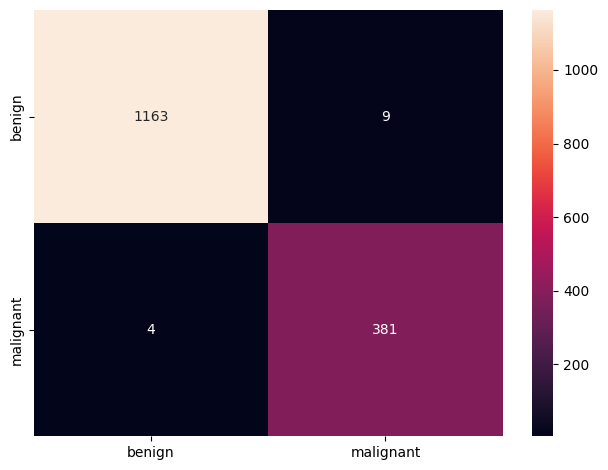

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import multilabel_confusion_matrix,confusion_matrix

classes=["benign","malignant"]
# Build confusion matrix
cf_matrix = confusion_matrix(y_true_b, y_pred_b)
df_cm = pd.DataFrame(cf_matrix ,index = [i for i in classes],
                     columns = [i for i in classes])

#df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10, index = [i for i in classes],
                     #columns = [i for i in classes])
#plt.figure(figsize = (8,4))
sn.heatmap(df_cm, annot=True,fmt="d")
#print(cf_matrix )
plt.tight_layout()
plt.savefig('integrated_data/figs/Int_b_conf.eps', format='eps')
plt.show()

In [23]:
from sklearn.metrics import confusion_matrix,recall_score,f1_score,precision_score,matthews_corrcoef,accuracy_score
import seaborn as sn
import pandas as pd
import numpy as np
val_loss1, val_accuracy1,y_pred1,y_true1 = validate(model,valid_dataloader1, optimizer, criterion)
#converting cuda list to cpu list and subsequently converting numpy
#to work with sklearn.matrics
y_pred1 = [tensor.cpu().numpy() for tensor in y_pred1]
y_true1=  [tensor.cpu().numpy() for tensor in y_true1]

x = [np.argmax(array) for array in y_pred1]
y_pred1_b = []
for index in x:
    if index > 4:
        y_pred1_b.append(np.array([1.]))
    else:
        y_pred1_b.append(np.array([0.]))
        
y = [np.argmax(array) for array in y_true1]
y_true1_b = []
for index in y:
    if index > 4:
        y_true1_b.append(np.array([1.]))
    else:
        y_true1_b.append(np.array([0.]))


#y_pred= torch.tensor(y_pred, device = 'cpu').detach().numpy() 
#y_true= torch.tensor(y_true, device = 'cpu').detach().numpy() 
accuracy =accuracy_score (y_true1_b, y_pred1_b)       
recall=recall_score(y_true1_b, y_pred1_b, average='weighted')
f1=f1_score(y_true1_b, y_pred1_b, average='weighted')
precision=precision_score(y_true1_b, y_pred1_b, labels=None, pos_label=1, average='weighted')
#mcc=matthews_corrcoef(y_true1, y_pred1, sample_weight=None)  
print("accuracy_40=",accuracy ,"recall_40=",recall,"F1-measure_40=",f1,"precision_40=" ,precision)

accuracy_40= 0.9973190348525469 recall_40= 0.9973190348525469 F1-measure_40= 0.9973148253860686 precision_40= 0.9973288552377024


In [24]:
from sklearn.metrics import classification_report
print(classification_report(y_true1_b, y_pred1_b, digits=3))

              precision    recall  f1-score   support

         0.0      0.996     1.000     0.998       272
         1.0      1.000     0.990     0.995       101

    accuracy                          0.997       373
   macro avg      0.998     0.995     0.997       373
weighted avg      0.997     0.997     0.997       373



In [25]:
from sklearn.metrics import confusion_matrix,recall_score,f1_score,precision_score,matthews_corrcoef,accuracy_score
import seaborn as sn
import pandas as pd
val_loss2, val_accuracy2,y_pred2,y_true2 = validate(model,valid_dataloader2, optimizer, criterion)
#converting cuda list to cpu list and subsequently converting numpy
#to work with sklearn.matrics
y_pred2 = [tensor.cpu().numpy() for tensor in y_pred2]
y_true2=  [tensor.cpu().numpy() for tensor in y_true2]

x = [np.argmax(array) for array in y_pred2]
y_pred2_b = []
for index in x:
    if index > 4:
        y_pred2_b.append(np.array([1.]))
    else:
        y_pred2_b.append(np.array([0.]))
        
y = [np.argmax(array) for array in y_true2]
y_true2_b = []
for index in y:
    if index > 4:
        y_true2_b.append(np.array([1.]))
    else:
        y_true2_b.append(np.array([0.]))


#y_pred= torch.tensor(y_pred, device = 'cpu').detach().numpy() 
#y_true= torch.tensor(y_true, device = 'cpu').detach().numpy() 
accuracy =accuracy_score (y_true2_b, y_pred2_b)       
recall=recall_score(y_true2_b, y_pred2_b, average='weighted')
f1=f1_score(y_true2_b, y_pred2_b, average='weighted')
precision=precision_score(y_true2_b, y_pred2_b, labels=None, pos_label=1, average='weighted')
#mcc=matthews_corrcoef(y_true1, y_pred1, sample_weight=None)  
print("accuracy_100=",accuracy ,"recall_100=",recall,"F1-measure_100=",f1,"precision_100=" ,precision)
#print("accuracy=",accuracy ,"recall=",recall,"F1-measure=",f1,"precision=" ,precision,"MCC=",mcc)

accuracy_100= 0.9954545454545455 recall_100= 0.9954545454545455 F1-measure_100= 0.9954683195592287 precision_100= 0.9955364455364455


In [26]:
from sklearn.metrics import classification_report
print(classification_report(y_true2_b, y_pred2_b, digits=3))

              precision    recall  f1-score   support

         0.0      1.000     0.994     0.997       331
         1.0      0.982     1.000     0.991       109

    accuracy                          0.995       440
   macro avg      0.991     0.997     0.994       440
weighted avg      0.996     0.995     0.995       440



In [27]:
from sklearn.metrics import confusion_matrix,recall_score,f1_score,precision_score,matthews_corrcoef,accuracy_score
import seaborn as sn
import pandas as pd
val_loss3, val_accuracy3,y_pred3,y_true3 = validate(model,valid_dataloader3, optimizer, criterion)
#converting cuda list to cpu list and subsequently converting numpy
#to work with sklearn.matrics
y_pred3 = [tensor.cpu().numpy() for tensor in y_pred3]
y_true3=  [tensor.cpu().numpy() for tensor in y_true3]

x = [np.argmax(array) for array in y_pred3]
y_pred3_b = []
for index in x:
    if index > 4:
        y_pred3_b.append(np.array([1.]))
    else:
        y_pred3_b.append(np.array([0.]))
        
y = [np.argmax(array) for array in y_true3]
y_true3_b = []
for index in y:
    if index > 4:
        y_true3_b.append(np.array([1.]))
    else:
        y_true3_b.append(np.array([0.]))

#y_pred= torch.tensor(y_pred, device = 'cpu').detach().numpy() 
#y_true= torch.tensor(y_true, device = 'cpu').detach().numpy() 
accuracy =accuracy_score (y_true3_b, y_pred3_b)       
recall=recall_score(y_true3_b, y_pred3_b, average='weighted')
f1=f1_score(y_true3_b, y_pred3_b, average='weighted')
precision=precision_score(y_true3_b, y_pred3_b, labels=None, pos_label=1, average='weighted')
#mcc=matthews_corrcoef(y_true1, y_pred1, sample_weight=None)  
print("accuracy_200=",accuracy ,"recall_200=",recall,"F1-measure_200=",f1,"precision_200=" ,precision)
#print("accuracy=",accuracy ,"recall=",recall,"F1-measure=",f1,"precision=" ,precision,"MCC=",mcc)

accuracy_200= 0.9844559585492227 recall_200= 0.9844559585492227 F1-measure_200= 0.9845661640881757 precision_200= 0.9849542609755453


In [28]:
from sklearn.metrics import classification_report
print(classification_report(y_true3_b, y_pred3_b, digits=3))

              precision    recall  f1-score   support

         0.0      0.997     0.983     0.990       293
         1.0      0.948     0.989     0.968        93

    accuracy                          0.984       386
   macro avg      0.972     0.986     0.979       386
weighted avg      0.985     0.984     0.985       386



In [29]:
from sklearn.metrics import confusion_matrix,recall_score,f1_score,precision_score,matthews_corrcoef,accuracy_score
import seaborn as sn
import pandas as pd
val_loss4, val_accuracy4,y_pred4,y_true4 = validate(model,valid_dataloader4, optimizer, criterion)
#converting cuda list to cpu list and subsequently converting numpy
#to work with sklearn.matrics
y_pred4 = [tensor.cpu().numpy() for tensor in y_pred4]
y_true4=  [tensor.cpu().numpy() for tensor in y_true4]

x = [np.argmax(array) for array in y_pred4]
y_pred4_b = []
for index in x:
    if index > 4:
        y_pred4_b.append(np.array([1.]))
    else:
        y_pred4_b.append(np.array([0.]))
        
y = [np.argmax(array) for array in y_true4]
y_true4_b = []
for index in y:
    if index > 4:
        y_true4_b.append(np.array([1.]))
    else:
        y_true4_b.append(np.array([0.]))


#y_pred= torch.tensor(y_pred, device = 'cpu').detach().numpy() 
#y_true= torch.tensor(y_true, device = 'cpu').detach().numpy() 
accuracy =accuracy_score (y_true4_b, y_pred4_b)       
recall=recall_score(y_true4_b, y_pred4_b, average='weighted')
f1=f1_score(y_true4_b, y_pred4_b, average='weighted')
precision=precision_score(y_true4_b, y_pred4_b, labels=None, pos_label=1, average='weighted')
#mcc=matthews_corrcoef(y_true1, y_pred1, sample_weight=None)  
print("accuracy_400=",accuracy ,"recall_400=",recall,"F1-measure_400=",f1,"precision_400=" ,precision)
#print("accuracy=",accuracy ,"recall=",recall,"F1-measure=",f1,"precision=" ,precision,"MCC=",mcc)

accuracy_400= 0.9888268156424581 recall_400= 0.9888268156424581 F1-measure_400= 0.9888268156424581 precision_400= 0.9888268156424581


In [30]:
from sklearn.metrics import classification_report
print(classification_report(y_true4_b, y_pred4_b, digits=3))

              precision    recall  f1-score   support

         0.0      0.993     0.993     0.993       276
         1.0      0.976     0.976     0.976        82

    accuracy                          0.989       358
   macro avg      0.984     0.984     0.984       358
weighted avg      0.989     0.989     0.989       358



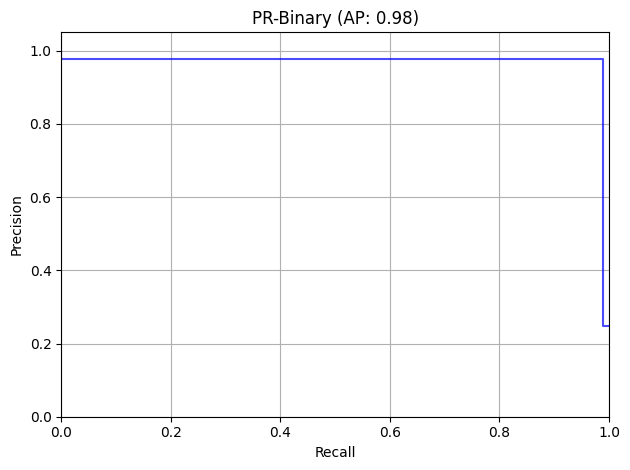

In [31]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve,auc


# Calculate precision and recall
precision, recall, _ = precision_recall_curve(y_true_b, y_pred_b)
pr_auc = auc(recall, precision)

# Plot the precision-recall curve
plt.step(recall, precision, color='b', alpha=0.7, where='post')
#plt.fill_between(recall, precision, step='post', alpha=0.3, color='b')

# Set labels and title
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('PR-Binary (AP: {:.2f})'.format(pr_auc))

# Set x and y axis limits
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.tight_layout()
plt.grid(True)  
# Show the plot
plt.show()


import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.metrics import precision_recall_curve, auc, confusion_matrix
import numpy as np

# Calculate precision and recall for precision-recall curve
precision, recall, _ = precision_recall_curve(y_true_b, y_pred_b)
pr_auc = auc(recall, precision)

# Plot the precision-recall curve
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Precision-Recall Curve
axes[0].step(recall, precision, color='b', alpha=0.7, where='post')
axes[0].set_xlabel('Recall')
axes[0].set_ylabel('Precision')
axes[0].set_title('PR-Binary (AP: {:.2f})'.format(pr_auc))
axes[0].set_xlim([0.0, 1.0])
axes[0].set_ylim([0.0, 1.05])
axes[0].grid(True)

# Confusion Matrix
classes = ["benign", "malignant"]
cf_matrix = confusion_matrix(y_true_b, y_pred_b)
df_cm = pd.DataFrame(cf_matrix, index=classes, columns=classes)
sn.heatmap(df_cm, annot=True, fmt="d", ax=axes[1])
axes[1].set_title('Confusion Matrix')
axes[1].set_xlabel('Predicted label')
axes[1].set_ylabel('True label')

plt.tight_layout()
plt.savefig('integrated_data/figs/figure_with_subcaptions.png')  # Save the figure
plt.show()


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


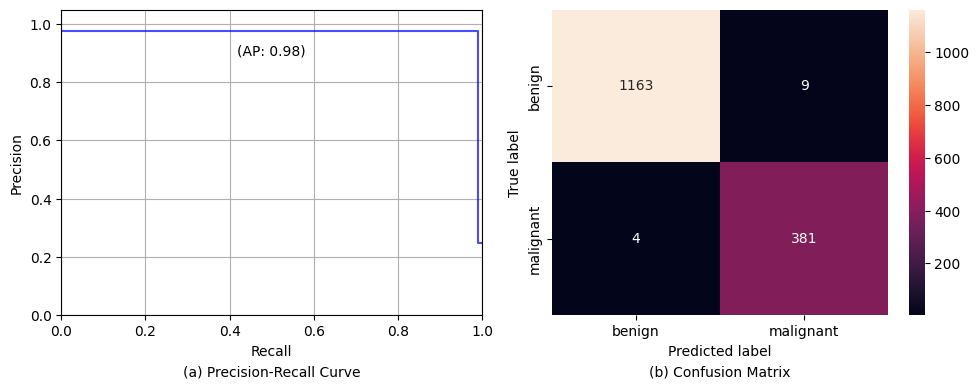

In [32]:
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.metrics import precision_recall_curve, auc, confusion_matrix
import numpy as np

# Calculate precision and recall for precision-recall curve
precision, recall, _ = precision_recall_curve(y_true_b, y_pred_b)
pr_auc = auc(recall, precision)

# Plot the precision-recall curve
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Precision-Recall Curve
axes[0].step(recall, precision, color='b', alpha=0.7, where='post')
axes[0].set_xlabel('Recall')
axes[0].set_ylabel('Precision')
#axes[0].set_title('Precision-Recall Curve')
axes[0].set_xlim([0.0, 1.0])
axes[0].set_ylim([0.0, 1.05])
axes[0].grid(True)
#axes[0].text(0.5, 0, 'Sub-caption 1', ha='center', va='top', transform=axes[0].transAxes)

# Confusion Matrix
classes = ["benign", "malignant"]
cf_matrix = confusion_matrix(y_true_b, y_pred_b)
df_cm = pd.DataFrame(cf_matrix, index=classes, columns=classes)
sn.heatmap(df_cm, annot=True, fmt="d", ax=axes[1])
#axes[1].set_title('Confusion Matrix')
axes[1].set_xlabel('Predicted label')
axes[1].set_ylabel('True label')
#axes[1].text(0.5, 0.95, 'Sub-caption 2', ha='center', va='top', transform=axes[1].transAxes)
axes[0].text(0.5, -0.2, "(a) Precision-Recall Curve", ha="center", transform=axes[0].transAxes)
axes[0].text(0.5, 0.85, "(AP: {:.2f})".format(pr_auc), ha="center", transform=axes[0].transAxes)
axes[1].text(0.5, -0.2, "(b) Confusion Matrix", ha="center", transform=axes[1].transAxes)
plt.tight_layout()
plt.savefig('integrated_data/figs/biprcon.eps',format='eps')  # Save the figure
plt.show()


In [ ]:
99.73 & 99.73 &99.73 &99.73
99.55 & 99.55 & 
accuracy_200= 0.9844559585492227 recall_200= 0.9844559585492227 F1-measure_200= 0.9845661640881757 precision_200= 0.9849542609755453
accuracy_400= 0.9888268156424581 recall_400= 0.9888268156424581 F1-measure_400= 0.9888268156424581 precision_400= 0.9888268156424581